In [57]:
import math
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

from acpi import ACPI
from acpi.utils import compute_coverage

In [51]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [77]:
# Read and preprocess data
def read_data(file, is_train=True):
    df = pd.read_csv(file, parse_dates=["datetime"])
    df = df.set_index("datetime")
    df = df.sort_index()
    
    df['holiday'] = df['holiday'].astype(bool)
    df['workingday'] = df['workingday'].astype(bool)
    df = df.fillna(method='ffill').fillna(method='bfill')
    
    # Create additional time-based features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['year'] = df.index.year
    
    return df

# Load data
train_df = read_data("data/train.csv")
test_df = read_data("data/test.csv", is_train=False)
print(train_df.shape)

# For the test set, we need to predict 'count', so we'll use features only
features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 
            'humidity', 'windspeed', 'hour', 'day_of_week', 'month', 'day', 'year']

# Prepare training data
X_train = train_df[features]
y_train = train_df['count']

# Prepare test data (we'll need to create sequences for time series models)
# For tree-based models, we can use the features directly
X_test = test_df[features]

# Since we don't have true values for test, we'll split training data for evaluation
# Let's use the last 30% of training data for validation
split_idx = int(len(train_df) * 0.7)
X_train_val = X_train.iloc[:split_idx]
y_train_val = y_train.iloc[:split_idx]
X_val = X_train.iloc[split_idx:]
y_val = y_train.iloc[split_idx:]

print(f"Training size: {len(X_train_val)}, Validation size: {len(X_val)}")

(10886, 16)
Training size: 7620, Validation size: 3266


Machine Learnings

In [78]:
# 1. Linear Regression
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_val, y_train_val)
lr_pred = lr_model.predict(X_val)

# 2. Random Forest
print("Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_val, y_train_val)
rf_pred = rf_model.predict(X_val)

# 3. Gradient Boosting
print("Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_val, y_train_val)
gb_pred = gb_model.predict(X_val)

Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...


TRANSFORMER

In [79]:
# SAME
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        # x: (B, T, D)
        return x + self.pe[:, : x.size(1)]

In [80]:
# SAME
class TransformerTimeSeriesModel(nn.Module):
    def __init__(
        self,
        input_size: int,
        d_model: int,
        nhead: int,
        num_layers: int,
        dim_feedforward: int,
        dropout: float,
        context_length: int,
        prediction_length: int,
        output_variance: bool = True,
    ):
        super().__init__()
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.d_model = d_model
        self.output_variance = output_variance

        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=context_length)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        out_dim = prediction_length * (2 if output_variance else 1)
        self.head = nn.Linear(d_model, out_dim)

    def forward(self, x):
        # x: (B, context_length, 1)
        h = self.input_proj(x)
        h = self.pos_enc(h)
        h = self.encoder(h)  # (B, T, D)
        # Use representation of last time step
        h_last = h[:, -1, :]  # (B, D)
        out = self.head(h_last)  # (B, pred_len*(...))
        if self.output_variance:
            mean, log_var = out.chunk(2, dim=-1)
            mean = mean.view(-1, self.prediction_length)
            log_var = log_var.view(-1, self.prediction_length)
            return mean, log_var.clamp(-7, 7)
        else:
            mean = out.view(-1, self.prediction_length)
            return mean, None

In [81]:
# Prepare sequences for transformer
def create_sequences(data, target, context_length, prediction_length):
    X, y = [], []
    for i in range(len(data) - context_length - prediction_length + 1):
        X.append(data[i:i + context_length])
        y.append(target[i + context_length:i + context_length + prediction_length])
    return np.array(X), np.array(y)

# Use only the 'count' column for transformer (univariate time series)
context_length = 24
prediction_length = 1

train_data = train_df['count'].values
X_seq_train, y_seq_train = create_sequences(train_data, train_data, context_length, prediction_length)

# Split for transformer
split_idx = int(len(X_seq_train) * 0.7)
X_seq_train_val = X_seq_train[:split_idx]
y_seq_train_val = y_seq_train[:split_idx]
X_seq_val = X_seq_train[split_idx:]
y_seq_val = y_seq_train[split_idx:]

# Convert to tensors
X_seq_train_val = torch.FloatTensor(X_seq_train_val).unsqueeze(-1)
y_seq_train_val = torch.FloatTensor(y_seq_train_val)
X_seq_val = torch.FloatTensor(X_seq_val).unsqueeze(-1)
y_seq_val = torch.FloatTensor(y_seq_val)

# Create DataLoader
train_dataset = TensorDataset(X_seq_train_val, y_seq_train_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize transformer model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformer_model = TransformerTimeSeriesModel(
    input_size=1,
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    context_length=context_length,
    prediction_length=prediction_length,
    output_variance=True,
).to(device)

# Train transformer
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)
num_epochs = 20

transformer_model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        mean_pred, log_var_pred = transformer_model(batch_x)
        
        if log_var_pred is not None:
            var_pred = torch.exp(log_var_pred)
            loss = 0.5 * (torch.log(2 * np.pi * var_pred) +
                         (batch_y - mean_pred)**2 / var_pred).mean()
        else:
            loss = nn.MSELoss()(mean_pred, batch_y)
            
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Make predictions with transformer
transformer_model.eval()
with torch.no_grad():
    X_seq_val_device = X_seq_val.to(device)
    transformer_pred, _ = transformer_model(X_seq_val_device)
    transformer_pred = transformer_pred.cpu().numpy().flatten()

# For the transformer, we need to align predictions with validation targets
transformer_y_val = y_seq_val.numpy().flatten()

Epoch [5/20], Loss: 7.4680
Epoch [10/20], Loss: 7.4722
Epoch [15/20], Loss: 7.4760
Epoch [20/20], Loss: 7.4738


In [83]:
# Wrapper for transformer model
class TransformerWrapper:
    def __init__(self, transformer_model, device, context_length):
        self.model = transformer_model
        self.device = device
        self.context_length = context_length
        self.model.eval()

    def predict(self, X):
        X_tensor = torch.FloatTensor(X).unsqueeze(-1).to(self.device)
        with torch.no_grad():
            mean_pred, _ = self.model(X_tensor)
            return mean_pred.cpu().numpy().flatten()

# Evaluate transformer on validation set
transformer_wrapper = TransformerWrapper(transformer_model, device, context_length)
y_pred_transformer = transformer_wrapper.predict(X_transformer_val)

# Calculate metrics for transformer
rmse_transformer = np.sqrt(mean_squared_error(y_transformer_val.numpy(), y_pred_transformer))
r2_transformer = r2_score(y_transformer_val.numpy(), y_pred_transformer)

results["Transformer"] = {
    "model": transformer_model,
    "predictions": y_pred_transformer,
    "rmse": rmse_transformer,
    "r2": r2_transformer
}

print(f"Transformer - RMSE: {rmse_transformer:.4f}, R²: {r2_transformer:.4f}")

AssertionError: query should be unbatched 2D or batched 3D tensor but received 4-D query tensor

arima

In [84]:
print("Training ARIMA Model...")
# For ARIMA, we'll use the entire time series
arima_data = train_df['count'].values

# We'll use the last portion for validation (same as other models)
arima_train = arima_data[:split_idx]
arima_val = arima_data[split_idx:split_idx+len(y_val)]

# Fit ARIMA model
try:
    # Try different orders to find the best one
    arima_model = ARIMA(arima_train, order=(2, 1, 2))
    arima_fit = arima_model.fit()
    
    # Make predictions
    arima_pred = arima_fit.forecast(steps=len(arima_val))
    
except Exception as e:
    print(f"ARIMA model failed with error: {e}")
    # Fallback to simple moving average
    arima_pred = np.mean(arima_train) * np.ones(len(arima_val))
    print("Using simple moving average as fallback")

Training ARIMA Model...


LSTM

In [85]:
print("Training LSTM Model...")
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Prepare data for LSTM (using the same sequences as transformer)
lstm_model = LSTMModel(
    input_size=1, 
    hidden_size=50, 
    num_layers=2, 
    output_size=1
).to(device)

# Train LSTM
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

lstm_model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer_lstm.zero_grad()
        
        outputs = lstm_model(batch_x)
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer_lstm.step()
        total_loss += loss.item()
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Make predictions with LSTM
lstm_model.eval()
with torch.no_grad():
    X_seq_val_device = X_seq_val.to(device)
    lstm_pred = lstm_model(X_seq_val_device)
    lstm_pred = lstm_pred.cpu().numpy().flatten()

lstm_y_val = y_seq_val.numpy().flatten()

Training LSTM Model...
Epoch [5/20], Loss: 33911.6894
Epoch [10/20], Loss: 23523.7706
Epoch [15/20], Loss: 16877.4443
Epoch [20/20], Loss: 12486.1509


In [86]:
# Wrapper class for ACPI
class ModelACPIWrapper:
    def __init__(self, model, model_type="tree"):
        self.model = model
        self.model_type = model_type
        
    def predict(self, X):
        if self.model_type == "transformer":
            # For transformer, we need to handle sequences
            X_tensor = torch.FloatTensor(X).unsqueeze(-1)
            with torch.no_grad():
                pred, _ = self.model(X_tensor)
                return pred.numpy().flatten()
        elif self.model_type == "lstm":
            # For LSTM, similar handling
            X_tensor = torch.FloatTensor(X).unsqueeze(-1)
            with torch.no_grad():
                pred = self.model(X_tensor)
                return pred.numpy().flatten()
        else:
            return self.model.predict(X)

# Prepare data for conformal prediction
def prepare_acpi_data(X, y, test_split=0.3, cal_split=0.5):
    n_test = int(len(X) * test_split)
    X_temp, X_test = X[:-n_test], X[-n_test:]
    y_temp, y_test = y[:-n_test], y[-n_test:]
    
    n_cal = int(len(X_temp) * cal_split)
    X_train, X_cal = X_temp[:-n_cal], X_temp[-n_cal:]
    y_train, y_cal = y_temp[:-n_cal], y_temp[-n_cal:]
    
    return X_train, X_cal, X_test, y_train, y_cal, y_test

# Initialize models and wrappers
models = {
    "Linear Regression": (lr_model, "tree"),
    "Random Forest": (rf_model, "tree"),
    "Gradient Boosting": (gb_model, "tree"),
    "Transformer": (transformer_model, "transformer"),
    "LSTM": (lstm_model, "lstm")
}

# For ARIMA, we'll handle it separately since it's a different type of model

# Prepare data for each model type
# For tree-based models
X_tree_train, X_tree_cal, X_tree_test, y_tree_train, y_tree_cal, y_tree_test = prepare_acpi_data(
    X_train_val.values, y_train_val.values
)

# For sequence models (transformer, LSTM)
X_seq_train, X_seq_cal, X_seq_test, y_seq_train, y_seq_cal, y_seq_test = prepare_acpi_data(
    X_seq_train_val.squeeze().numpy(), y_seq_train_val.numpy().flatten()
)

# Results storage
results = []

# Evaluate each model
alpha = 0.1  # 90% prediction intervals

for model_name, (model, model_type) in models.items():
    print(f"\nEvaluating {model_name}...")
    
    # Select appropriate data based on model type
    if model_type in ["transformer", "lstm"]:
        X_cal = X_seq_cal
        y_cal = y_seq_cal
        X_test = X_seq_test
        y_test = y_seq_test
    else:
        X_cal = X_tree_cal
        y_cal = y_tree_cal
        X_test = X_tree_test
        y_test = y_tree_test
    
    # Create wrapper
    wrapper = ModelACPIWrapper(model, model_type)
    
    # Initialize ACPI
    acpi = ACPI(
        model_cali=wrapper,
        n_estimators=100,
        max_depth=20,
        min_node_size=10
    )
    
    # Fit ACPI on calibration data
    acpi.fit(X_cal, y_cal, nonconformity_func=None)
    
    # Fit calibration
    acpi.fit_calibration(X_cal, y_cal, nonconformity_func=None, quantile=1-alpha, only_qrf=True)
    
    # Generate prediction intervals
    y_lower, y_upper = acpi.predict_pi(X_test, method='qrf')
    
    # Compute coverage
    coverage = compute_coverage(y_test, y_lower, y_upper)
    
    # Calculate metrics
    y_pred = wrapper.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Calculate average interval width
    avg_width = np.mean(y_upper - y_lower)
    
    # Store results
    results.append({
        "Model": model_name,
        "RMSE": rmse,
        "R2": r2,
        "Coverage": coverage,
        "Avg_Width": avg_width
    })
    
    print(f"RMSE: {rmse:.4f}, R2: {r2:.4f}, Coverage: {coverage:.4f}, Avg Width: {avg_width:.4f}")

# Evaluate ARIMA separately
print("\nEvaluating ARIMA...")
# For ARIMA, we need to use a different approach for conformal prediction
# We'll use a simple approach based on residuals

# Calculate ARIMA residuals on training data
arima_train_pred = arima_fit.fittedvalues if 'arima_fit' in locals() else arima_train[:-1]
arima_residuals = arima_train[len(arima_train)-len(arima_train_pred):] - arima_train_pred

# Calculate prediction intervals based on residuals
alpha = 0.1
quantile = np.quantile(np.abs(arima_residuals), 1 - alpha)

arima_pred = arima_pred[:len(arima_val)]  # Ensure same length
arima_lower = arima_pred - quantile
arima_upper = arima_pred + quantile

# Calculate metrics for ARIMA
arima_rmse = np.sqrt(mean_squared_error(arima_val, arima_pred))
arima_r2 = r2_score(arima_val, arima_pred)
arima_coverage = np.mean((arima_val >= arima_lower) & (arima_val <= arima_upper))
arima_avg_width = np.mean(arima_upper - arima_lower)

results.append({
    "Model": "ARIMA",
    "RMSE": arima_rmse,
    "R2": arima_r2,
    "Coverage": arima_coverage,
    "Avg_Width": arima_avg_width
})

print(f"ARIMA - RMSE: {arima_rmse:.4f}, R2: {arima_r2:.4f}, Coverage: {arima_coverage:.4f}, Avg Width: {arima_avg_width:.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df)


Evaluating Linear Regression...


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


RMSE: 146.8971, R2: 0.3396, Coverage: 0.6645, Avg Width: 279.1751

Evaluating Random Forest...


100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


RMSE: 16.2049, R2: 0.9920, Coverage: 0.8806, Avg Width: 47.4717

Evaluating Gradient Boosting...


100%|██████████| 50/50 [00:27<00:00,  1.82it/s]


RMSE: 68.5330, R2: 0.8563, Coverage: 0.8141, Avg Width: 141.7989

Evaluating Transformer...


100%|██████████| 50/50 [01:46<00:00,  2.14s/it]


RMSE: 99.5474, R2: 0.6976, Coverage: 0.8829, Avg Width: 220.3134

Evaluating LSTM...


100%|██████████| 50/50 [02:08<00:00,  2.57s/it]


RMSE: 147.8745, R2: 0.3328, Coverage: 0.8425, Avg Width: 236.0269

Evaluating ARIMA...
ARIMA - RMSE: 341.3553, R2: -1.4212, Coverage: 0.3261, Avg Width: 249.2309

Results Summary:
               Model        RMSE        R2  Coverage   Avg_Width
0  Linear Regression  146.897115  0.339598  0.664479  279.175075
1      Random Forest   16.204913  0.991963  0.880577   47.471712
2  Gradient Boosting   68.533044  0.856258  0.814086  141.798850
3        Transformer   99.547433  0.697632  0.882895  220.313378
4               LSTM  147.874498  0.332792  0.842544  236.026891
5              ARIMA  341.355334 -1.421159  0.326087  249.230890



📊 INDIVIDUAL MODEL PREDICTION VISUALIZATIONS

📈 Creating plots for Linear Regression...


100%|██████████| 50/50 [00:27<00:00,  1.84it/s]


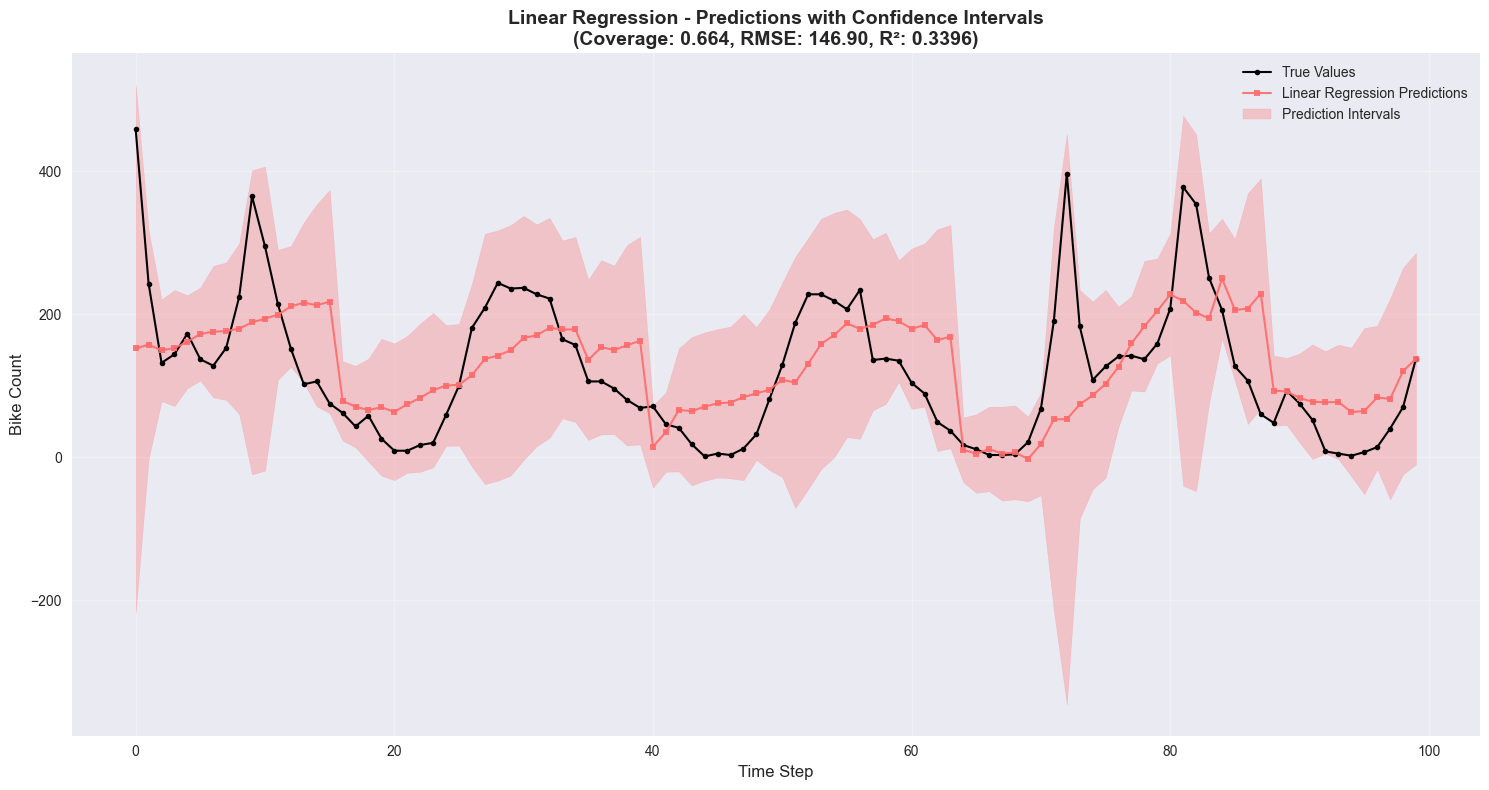

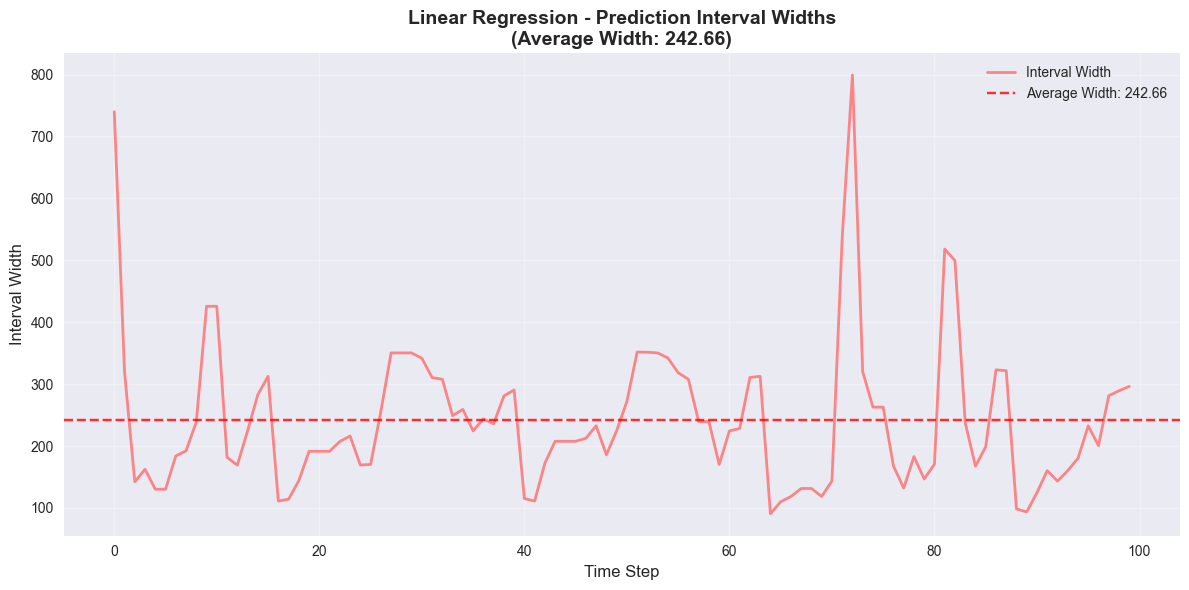

   ✅ Coverage: 0.664 (Target: 0.900)
   ✅ RMSE: 146.90
   ✅ R²: 0.3396
   ✅ Avg Interval Width: 279.18

📈 Creating plots for Random Forest...


100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


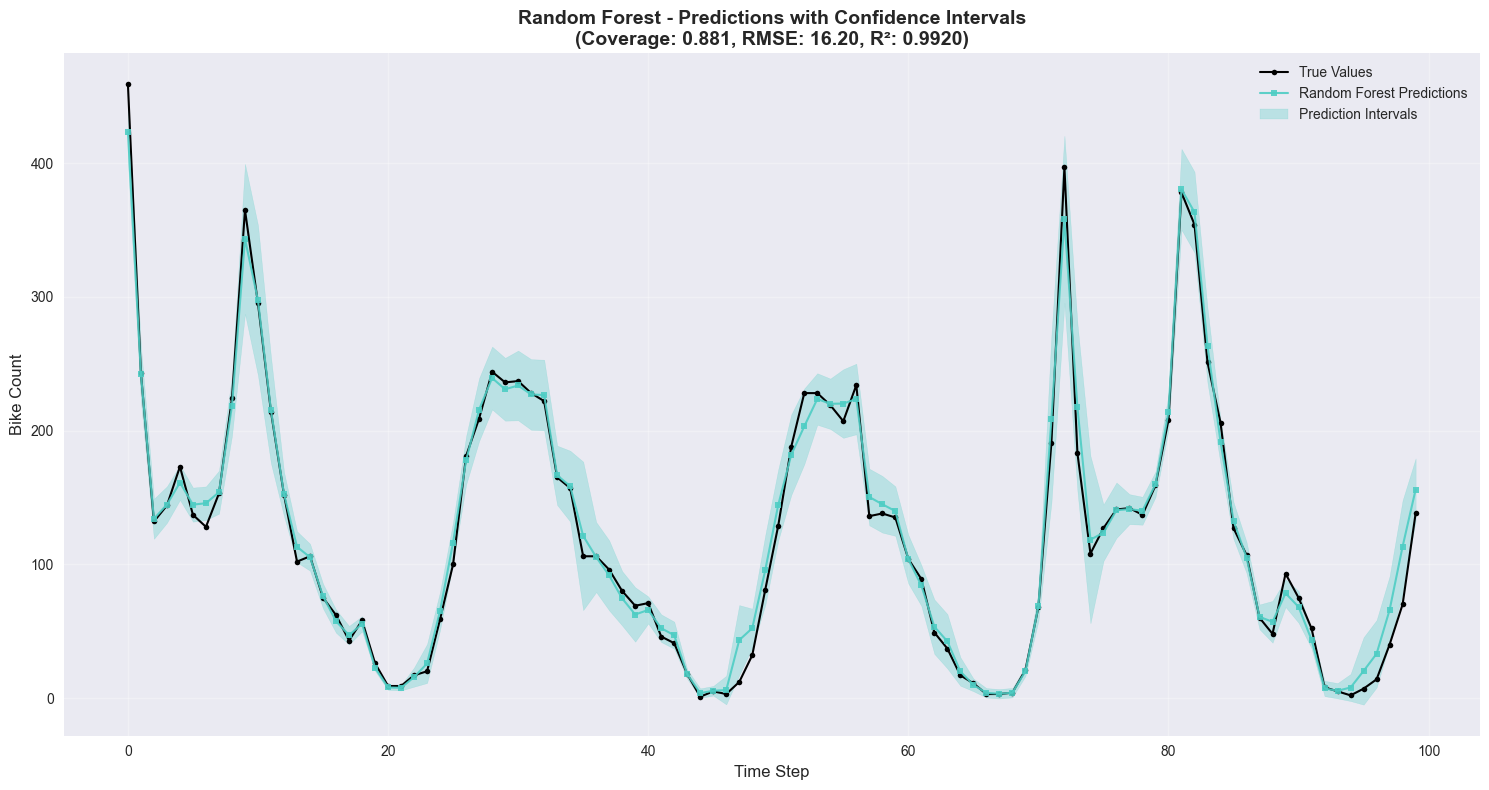

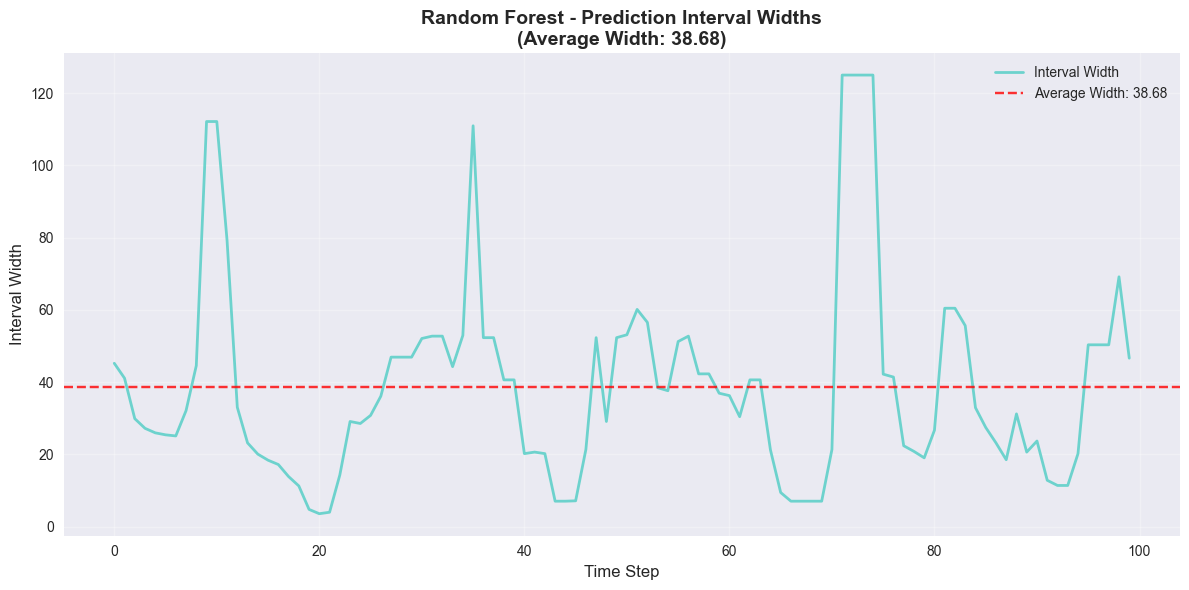

   ✅ Coverage: 0.881 (Target: 0.900)
   ✅ RMSE: 16.20
   ✅ R²: 0.9920
   ✅ Avg Interval Width: 47.47

📈 Creating plots for Gradient Boosting...


100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


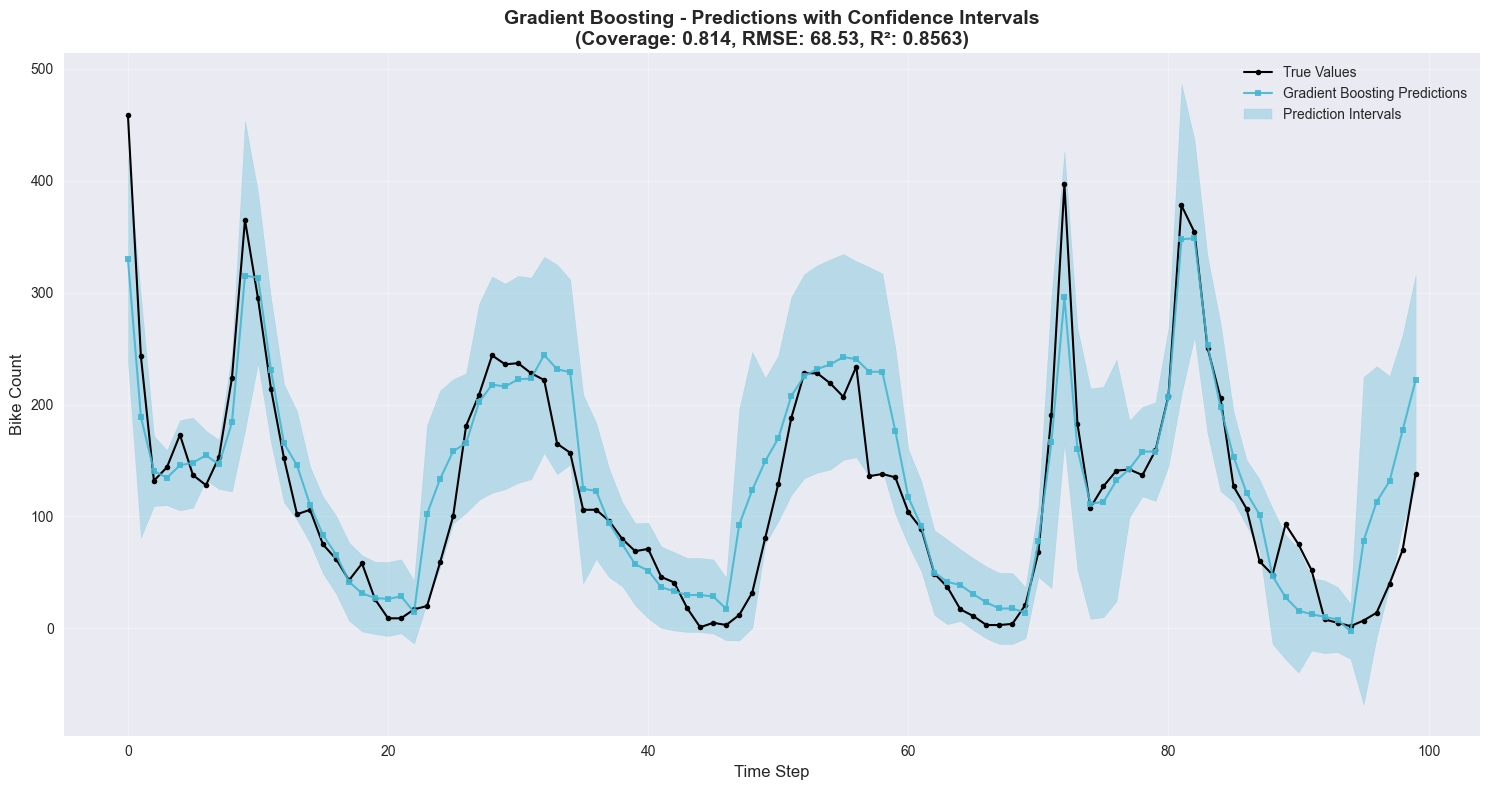

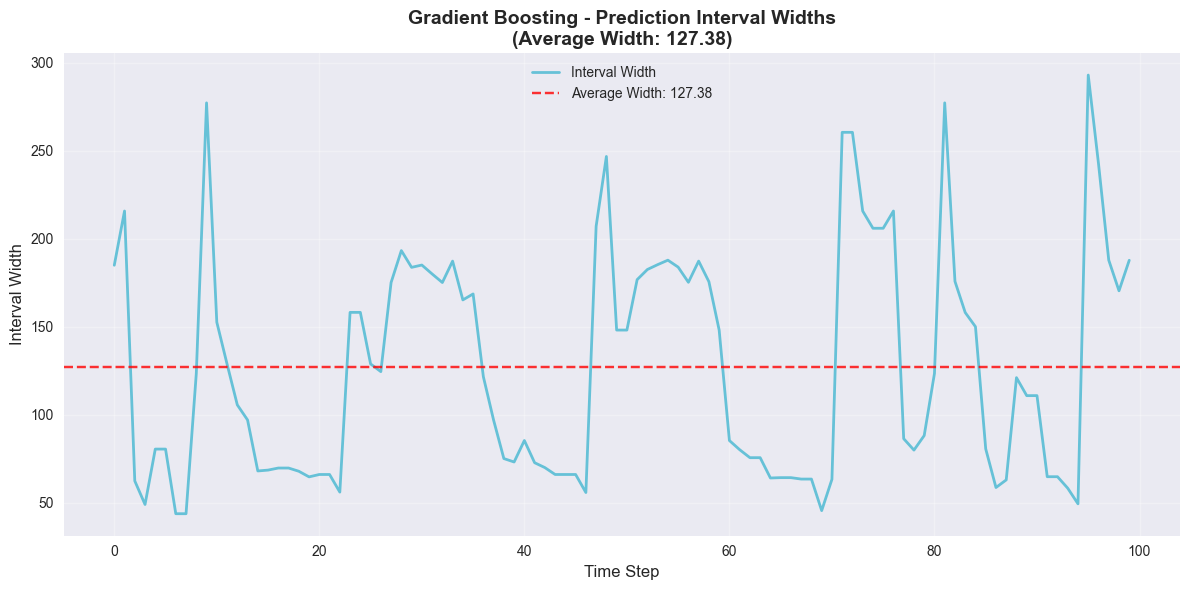

   ✅ Coverage: 0.814 (Target: 0.900)
   ✅ RMSE: 68.53
   ✅ R²: 0.8563
   ✅ Avg Interval Width: 141.80

📈 Creating plots for Transformer...


100%|██████████| 50/50 [01:45<00:00,  2.11s/it]


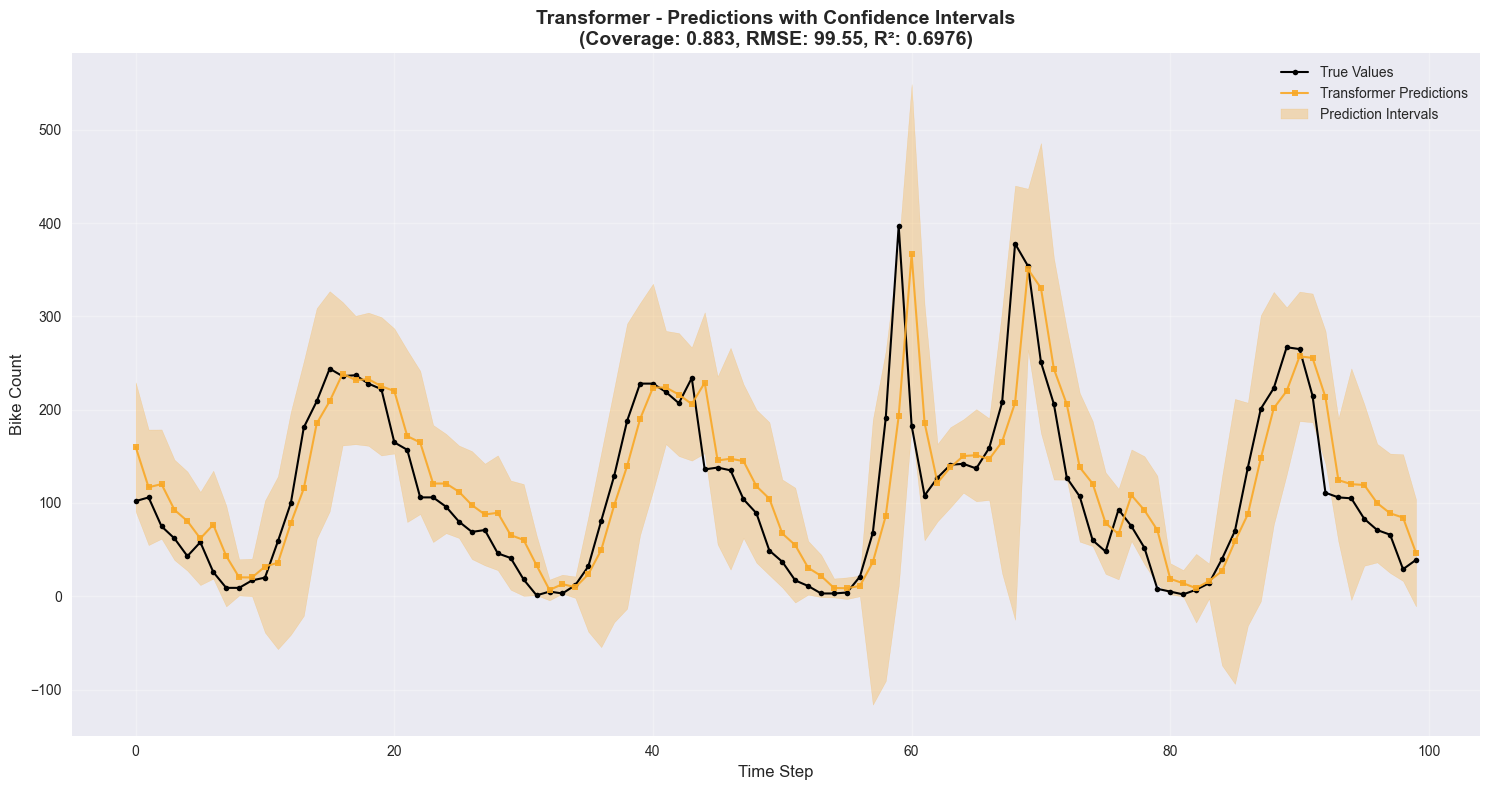

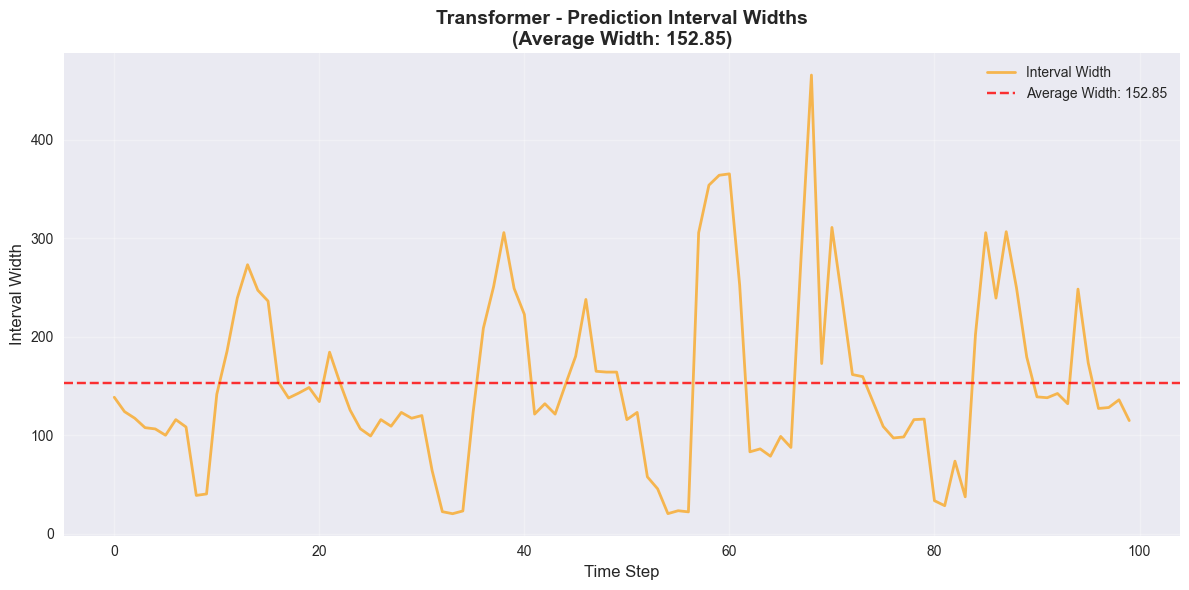

   ✅ Coverage: 0.883 (Target: 0.900)
   ✅ RMSE: 99.55
   ✅ R²: 0.6976
   ✅ Avg Interval Width: 220.31

📈 Creating plots for LSTM...


100%|██████████| 50/50 [01:46<00:00,  2.14s/it]


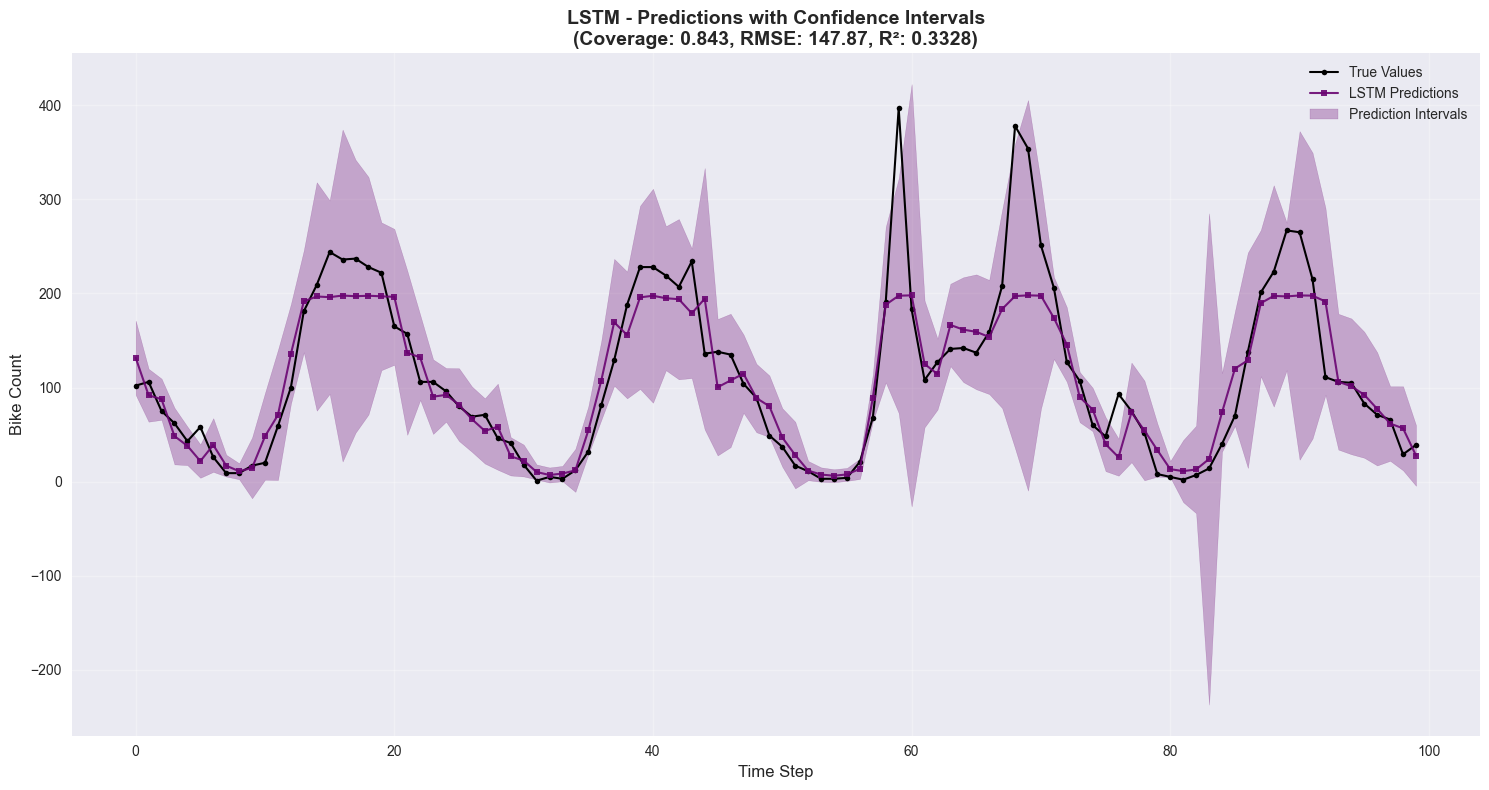

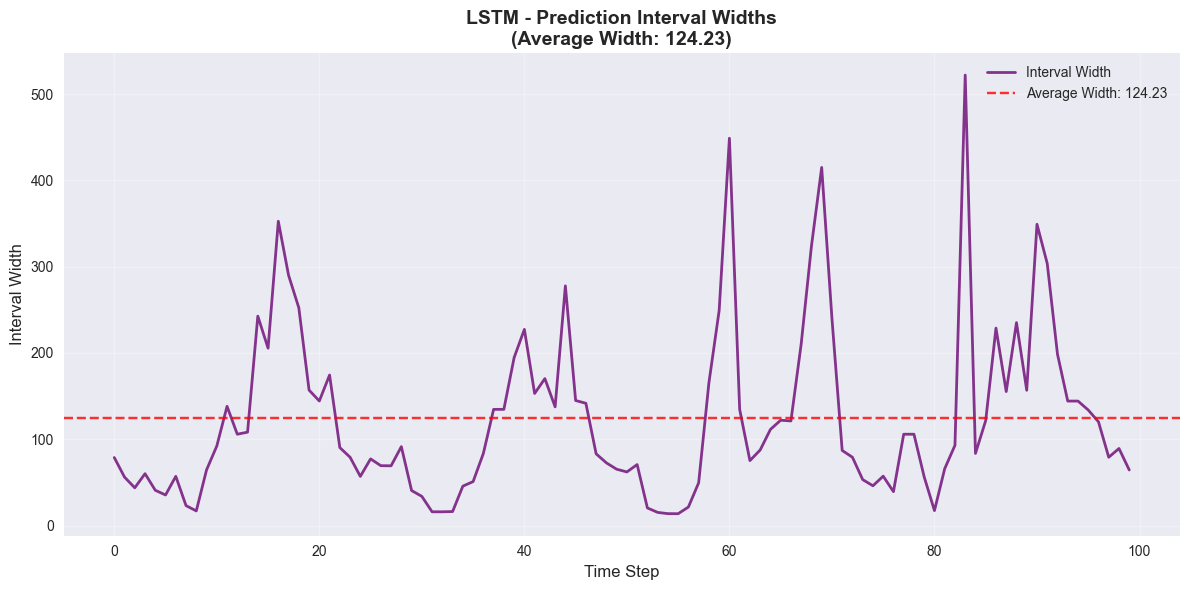

   ✅ Coverage: 0.843 (Target: 0.900)
   ✅ RMSE: 147.87
   ✅ R²: 0.3328
   ✅ Avg Interval Width: 236.03

📈 Creating plots for ARIMA...
   ⏩ Skipping ARIMA plots (different data structure)

📈 Creating plots for ARIMA...


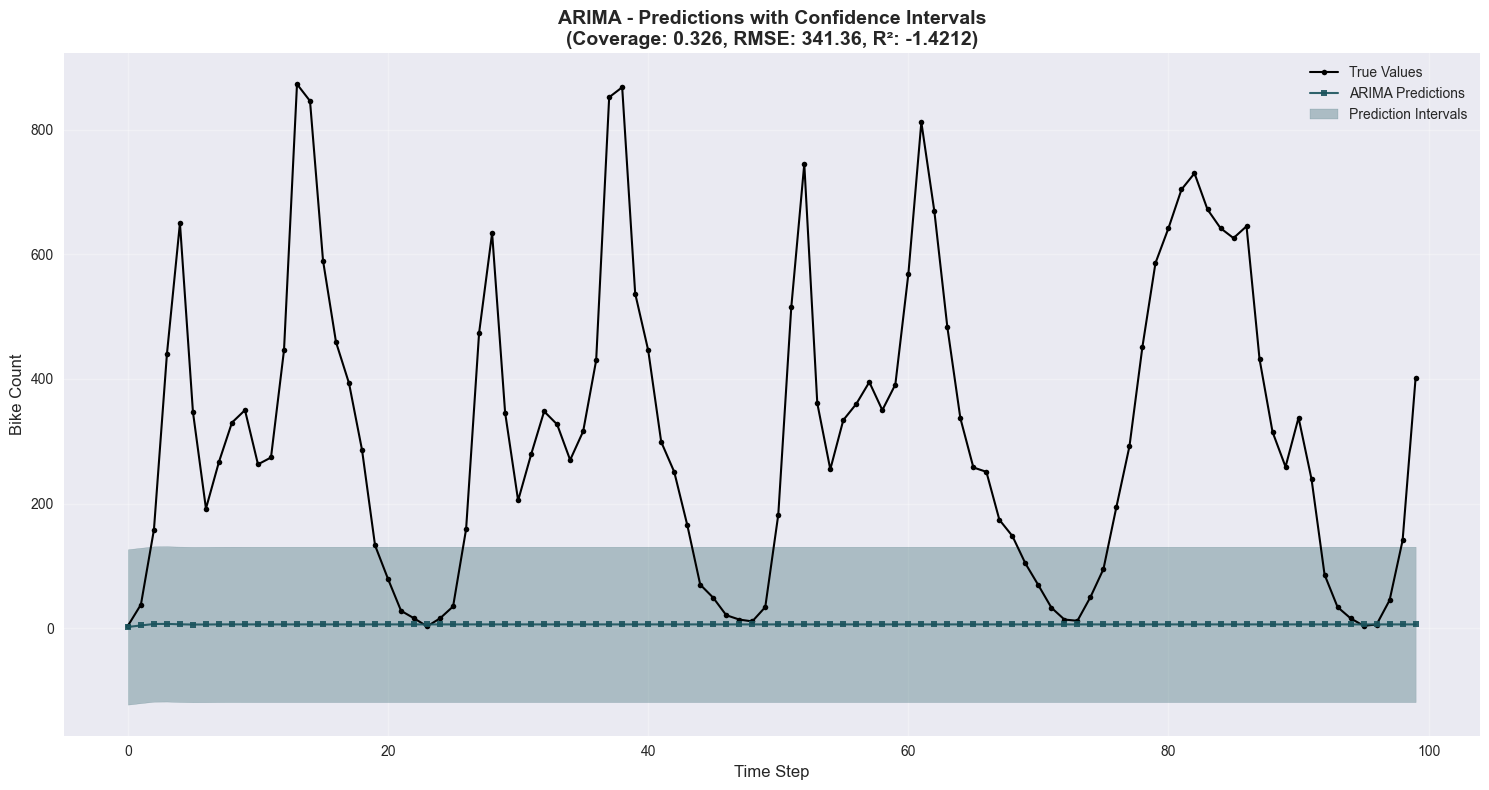

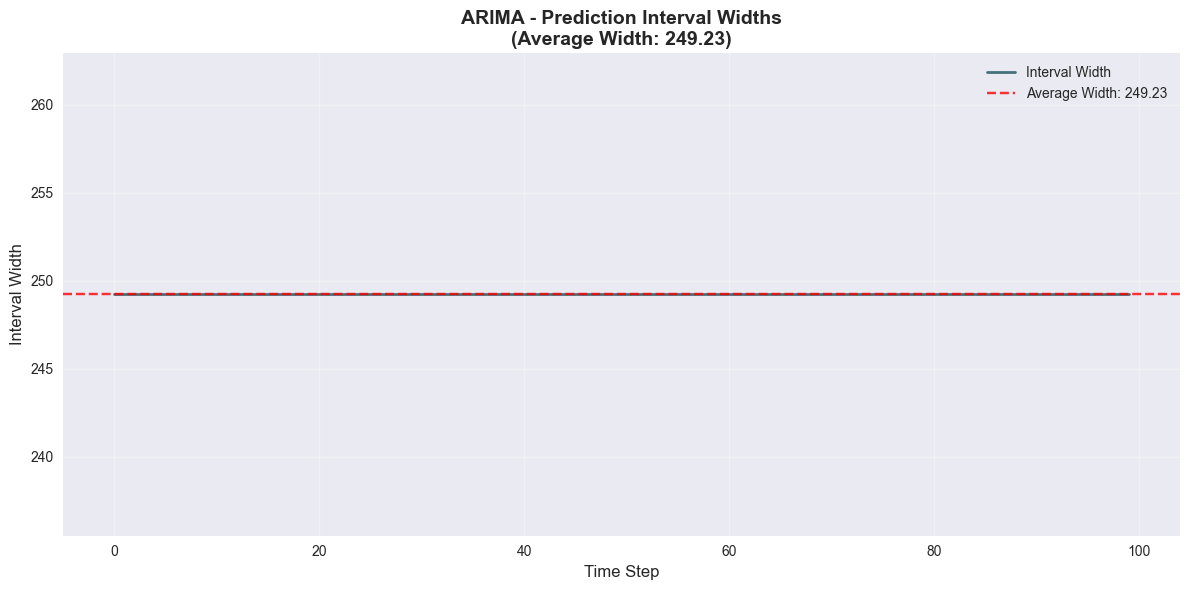


📊 COMPARISON OF ALL MODELS' INTERVAL WIDTHS


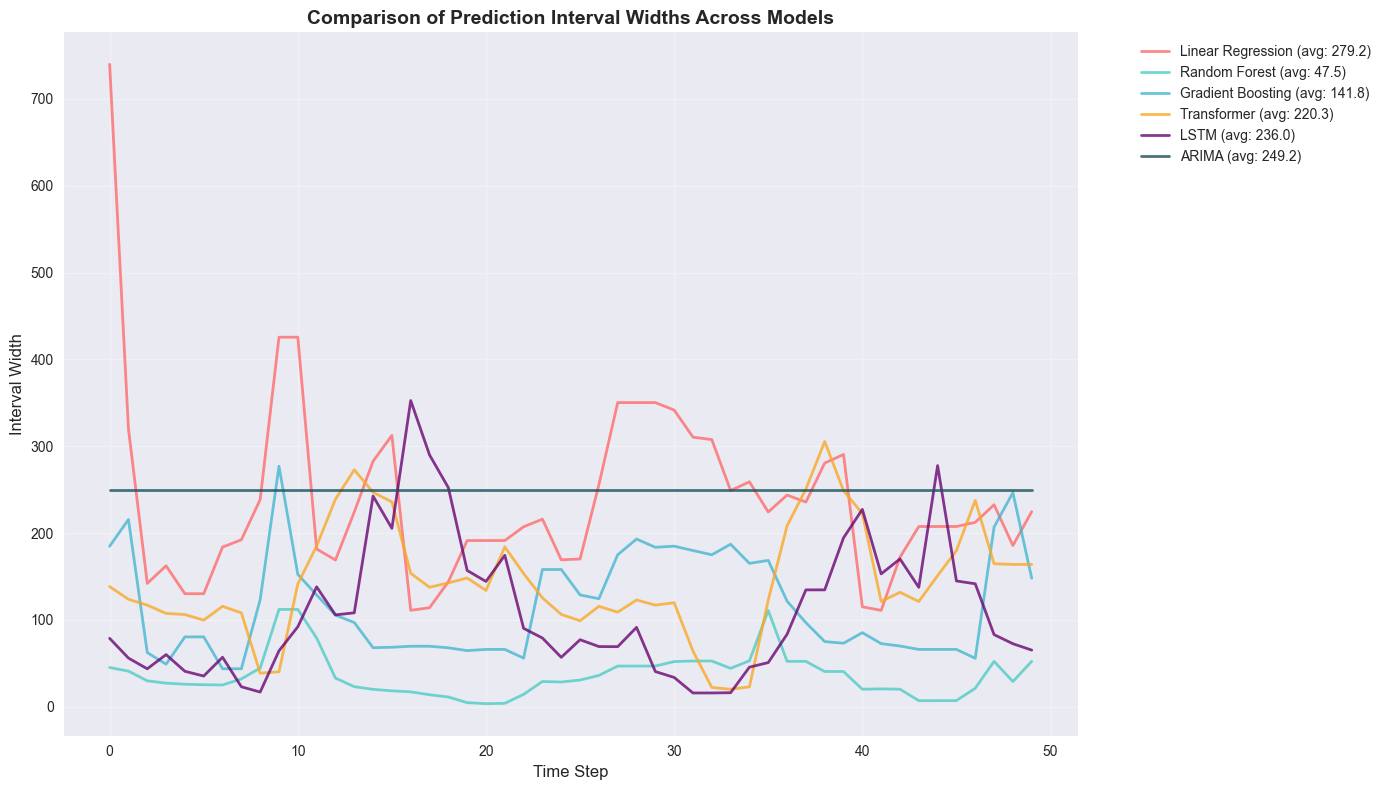


📊 COVERAGE COMPARISON ACROSS MODELS


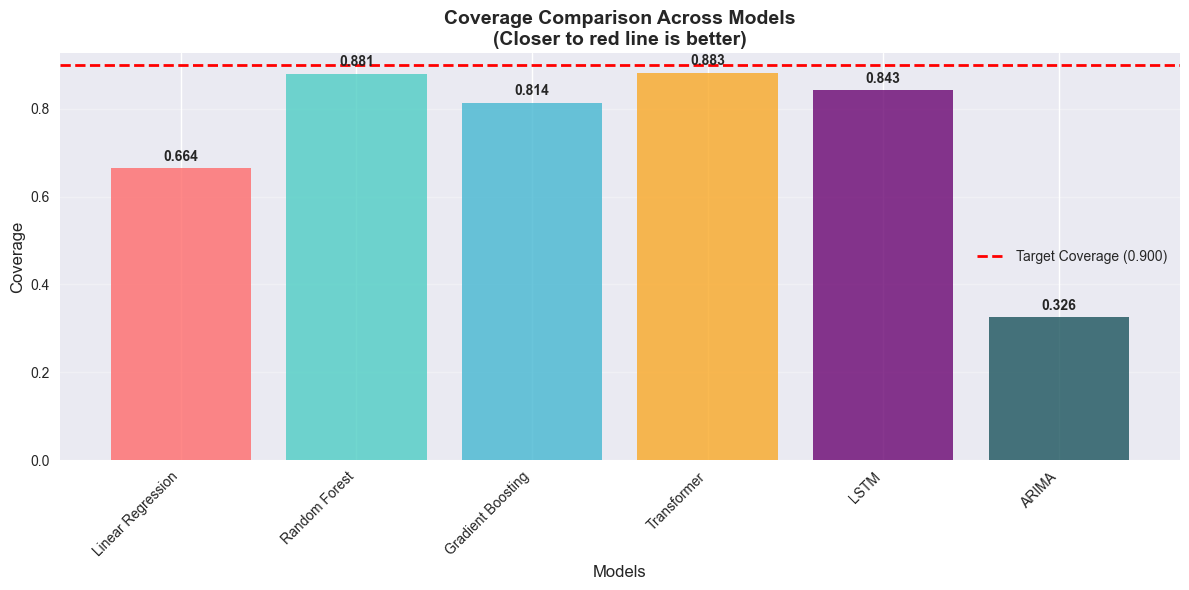


📊 RMSE COMPARISON ACROSS MODELS


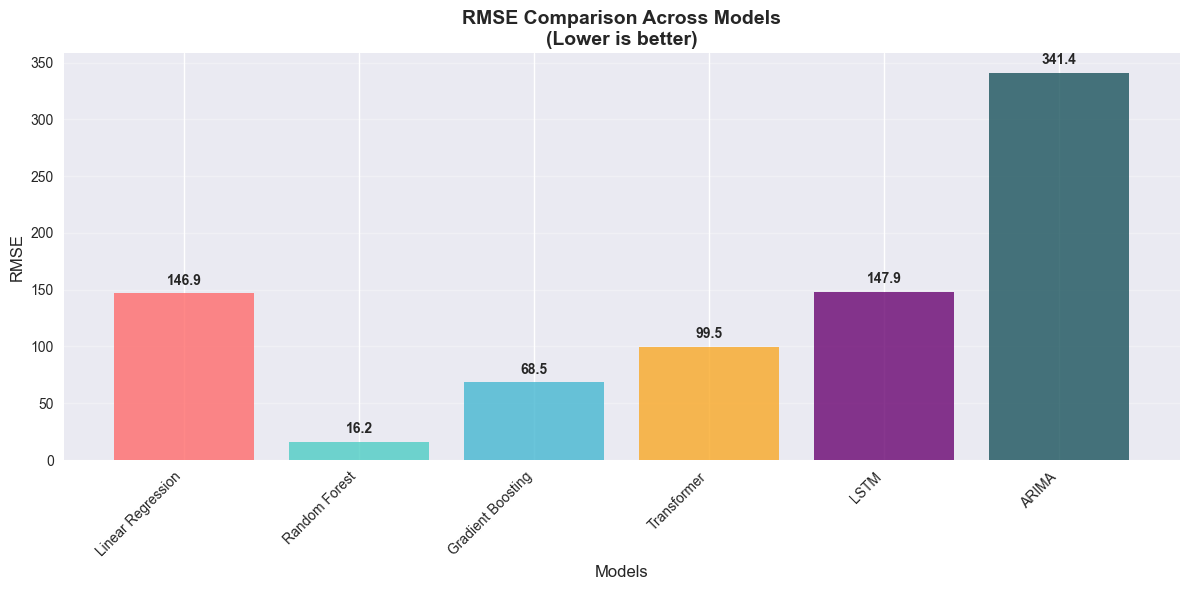


🎯 KEY INSIGHTS FROM THE ANALYSIS
🏆 Best model by RMSE: Random Forest (16.20)
🎯 Best model by Coverage: Transformer (0.883)
📏 Most confident model: Random Forest (width: 47.47)
❌ No model achieved target coverage of 0.900
   Closest: Transformer (0.883)

📋 RECOMMENDATIONS:
🎯 For accuracy: Use Random Forest (RMSE: 16.20)
🎯 For reliability: Use Transformer (Coverage: 0.883)
💡 Consider ensemble approach combining both models
📊 Detailed results saved to: model_comparison_results.csv


In [91]:
# Create individual prediction plots for each model in simple style
print("\n" + "="*80)
print("📊 INDIVIDUAL MODEL PREDICTION VISUALIZATIONS")
print("="*80)

# Define colors for each model
model_colors = {
    'Linear Regression': '#FF6B6B',
    'Random Forest': '#4ECDC4', 
    'Gradient Boosting': '#45B7D1',
    'Transformer': '#F9A826',
    'LSTM': '#6A0572',
    'ARIMA': '#1A535C'
}

# Store all model data for later use
all_models_data = {}

# Create prediction plots for each model
n_plot = 100  # Number of points to plot

for i, row in results_df.iterrows():
    model_name = row['Model']
    print(f"\n📈 Creating plots for {model_name}...")
    
    # Get model-specific data based on model type
    if model_name == "Linear Regression":
        X_cal = X_tree_cal
        y_cal = y_tree_cal
        X_test = X_tree_test
        y_test = y_tree_test
        model = lr_model
        model_type = "tree"
        
    elif model_name == "Random Forest":
        X_cal = X_tree_cal
        y_cal = y_tree_cal
        X_test = X_tree_test
        y_test = y_tree_test
        model = rf_model
        model_type = "tree"
        
    elif model_name == "Gradient Boosting":
        X_cal = X_tree_cal
        y_cal = y_tree_cal
        X_test = X_tree_test
        y_test = y_tree_test
        model = gb_model
        model_type = "tree"
        
    elif model_name == "Transformer":
        X_cal = X_seq_cal
        y_cal = y_seq_cal
        X_test = X_seq_test
        y_test = y_seq_test
        model = transformer_model
        model_type = "transformer"
        
    elif model_name == "LSTM":
        X_cal = X_seq_cal
        y_cal = y_seq_cal
        X_test = X_seq_test
        y_test = y_seq_test
        model = lstm_model
        model_type = "lstm"
        
    elif model_name == "ARIMA":
        # ARIMA handled separately - skip plotting for now or use different approach
        print("   ⏩ Skipping ARIMA plots (different data structure)")
        continue
    
    # Create wrapper and get predictions
    wrapper = ModelACPIWrapper(model, model_type)
    
    # Initialize ACPI
    acpi = ACPI(
        model_cali=wrapper,
        n_estimators=100,
        max_depth=20,
        min_node_size=10
    )
    
    # Fit ACPI
    acpi.fit(X_cal, y_cal, nonconformity_func=None)
    acpi.fit_calibration(X_cal, y_cal, nonconformity_func=None, quantile=1-alpha, only_qrf=True)
    
    # Generate prediction intervals
    y_lower, y_upper = acpi.predict_pi(X_test, method='qrf')
    y_pred = wrapper.predict(X_test)
    
    # Store data for this model
    all_models_data[model_name] = {
        'y_test': y_test,
        'y_pred': y_pred,
        'y_lower': y_lower,
        'y_upper': y_upper,
        'coverage': row['Coverage'],
        'rmse': row['RMSE'],
        'r2': row['R2'],
        'avg_width': row['Avg_Width']
    }
    
    # Plot 1: Predictions with intervals
    plt.figure(figsize=(15, 8))
    
    # Plot true values
    plt.plot(range(n_plot), y_test[:n_plot], 'o-', 
             label='True Values', color='black', markersize=4, linewidth=1.5)
    
    # Plot model predictions
    plt.plot(range(n_plot), y_pred[:n_plot], 's-', 
             label=f'{model_name} Predictions', color=model_colors[model_name], 
             markersize=4, alpha=0.9, linewidth=1.5)
    
    # Plot prediction intervals
    plt.fill_between(range(n_plot), y_lower[:n_plot], y_upper[:n_plot],
                    alpha=0.3, label='Prediction Intervals', color=model_colors[model_name])
    
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Bike Count', fontsize=12)
    plt.title(f'{model_name} - Predictions with Confidence Intervals\n'
             f'(Coverage: {row["Coverage"]:.3f}, RMSE: {row["RMSE"]:.2f}, R²: {row["R2"]:.4f})', 
             fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Interval widths
    plt.figure(figsize=(12, 6))
    
    interval_widths = y_upper - y_lower
    plt.plot(range(n_plot), interval_widths[:n_plot], 
             color=model_colors[model_name], linewidth=2, alpha=0.8,
             label='Interval Width')
    
    # Add average width line
    avg_width = np.mean(interval_widths[:n_plot])
    plt.axhline(y=avg_width, color='red', linestyle='--', alpha=0.8,
               label=f'Average Width: {avg_width:.2f}')
    
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Interval Width', fontsize=12)
    plt.title(f'{model_name} - Prediction Interval Widths\n'
             f'(Average Width: {avg_width:.2f})', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print quick stats
    print(f"   ✅ Coverage: {row['Coverage']:.3f} (Target: {1-alpha:.3f})")
    print(f"   ✅ RMSE: {row['RMSE']:.2f}")
    print(f"   ✅ R²: {row['R2']:.4f}")
    print(f"   ✅ Avg Interval Width: {row['Avg_Width']:.2f}")

# Handle ARIMA separately if it exists
if 'ARIMA' in results_df['Model'].values:
    print(f"\n📈 Creating plots for ARIMA...")
    arima_row = results_df[results_df['Model'] == 'ARIMA'].iloc[0]
    
    # For ARIMA, we need to use the validation data
    plt.figure(figsize=(15, 8))
    
    # Plot true values
    plt.plot(range(n_plot), arima_val[:n_plot], 'o-', 
             label='True Values', color='black', markersize=4, linewidth=1.5)
    
    # Plot ARIMA predictions
    plt.plot(range(n_plot), arima_pred[:n_plot], 's-', 
             label='ARIMA Predictions', color=model_colors['ARIMA'], 
             markersize=4, alpha=0.9, linewidth=1.5)
    
    # Plot prediction intervals
    plt.fill_between(range(n_plot), arima_lower[:n_plot], arima_upper[:n_plot],
                    alpha=0.3, label='Prediction Intervals', color=model_colors['ARIMA'])
    
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Bike Count', fontsize=12)
    plt.title(f'ARIMA - Predictions with Confidence Intervals\n'
             f'(Coverage: {arima_row["Coverage"]:.3f}, RMSE: {arima_row["RMSE"]:.2f}, R²: {arima_row["R2"]:.4f})', 
             fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot ARIMA interval widths
    plt.figure(figsize=(12, 6))
    
    arima_interval_widths = arima_upper - arima_lower
    plt.plot(range(n_plot), arima_interval_widths[:n_plot], 
             color=model_colors['ARIMA'], linewidth=2, alpha=0.8,
             label='Interval Width')
    
    # Add average width line
    arima_avg_width = np.mean(arima_interval_widths[:n_plot])
    plt.axhline(y=arima_avg_width, color='red', linestyle='--', alpha=0.8,
               label=f'Average Width: {arima_avg_width:.2f}')
    
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Interval Width', fontsize=12)
    plt.title(f'ARIMA - Prediction Interval Widths\n'
             f'(Average Width: {arima_avg_width:.2f})', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Create comparison plot of all models' interval widths
print("\n" + "="*80)
print("📊 COMPARISON OF ALL MODELS' INTERVAL WIDTHS")
print("="*80)

plt.figure(figsize=(14, 8))

# Plot interval widths for all models (first 50 points for clarity)
for model_name, model_data in all_models_data.items():
    interval_widths = model_data['y_upper'] - model_data['y_lower']
    plt.plot(range(50), interval_widths[:50], 
             color=model_colors[model_name], linewidth=2, alpha=0.8,
             label=f'{model_name} (avg: {model_data["avg_width"]:.1f})')

# Add ARIMA if available
if 'ARIMA' in results_df['Model'].values:
    plt.plot(range(50), arima_interval_widths[:50], 
             color=model_colors['ARIMA'], linewidth=2, alpha=0.8,
             label=f'ARIMA (avg: {arima_avg_width:.1f})')

plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Interval Width', fontsize=12)
plt.title('Comparison of Prediction Interval Widths Across Models', 
         fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create coverage comparison bar chart
print("\n" + "="*80)
print("📊 COVERAGE COMPARISON ACROSS MODELS")
print("="*80)

plt.figure(figsize=(12, 6))
models_list = results_df['Model']
coverages = results_df['Coverage']

bars = plt.bar(models_list, coverages, color=[model_colors[m] for m in models_list], alpha=0.8)

# Add target coverage line
plt.axhline(y=1-alpha, color='red', linestyle='--', linewidth=2, 
           label=f'Target Coverage ({1-alpha:.3f})')

# Add value labels on bars
for bar, coverage in zip(bars, coverages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{coverage:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Models', fontsize=12)
plt.ylabel('Coverage', fontsize=12)
plt.title('Coverage Comparison Across Models\n(Closer to red line is better)', 
         fontsize=14, fontweight='bold')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Create RMSE comparison bar chart
print("\n" + "="*80)
print("📊 RMSE COMPARISON ACROSS MODELS")
print("="*80)

plt.figure(figsize=(12, 6))
rmses = results_df['RMSE']

bars = plt.bar(models_list, rmses, color=[model_colors[m] for m in models_list], alpha=0.8)

# Add value labels on bars
for bar, rmse in zip(bars, rmses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{rmse:.1f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Models', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('RMSE Comparison Across Models\n(Lower is better)', 
         fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Final summary
print("\n" + "="*80)
print("🎯 KEY INSIGHTS FROM THE ANALYSIS")
print("="*80)

# Find best model by RMSE
best_rmse_model = results_df.loc[results_df['RMSE'].idxmin()]
print(f"🏆 Best model by RMSE: {best_rmse_model['Model']} ({best_rmse_model['RMSE']:.2f})")

# Find best model by Coverage
best_coverage_model = results_df.loc[results_df['Coverage'].idxmax()]
print(f"🎯 Best model by Coverage: {best_coverage_model['Model']} ({best_coverage_model['Coverage']:.3f})")

# Find best model by Interval Width (narrowest)
best_width_model = results_df.loc[results_df['Avg_Width'].idxmin()]
print(f"📏 Most confident model: {best_width_model['Model']} (width: {best_width_model['Avg_Width']:.2f})")

# Check if any model achieved target coverage
target_coverage = 1 - alpha
achieved_target = results_df[results_df['Coverage'] >= target_coverage]
if len(achieved_target) > 0:
    print(f"✅ Models that achieved target coverage ({target_coverage:.3f}):")
    for _, row in achieved_target.iterrows():
        print(f"   - {row['Model']}: {row['Coverage']:.3f}")
else:
    print(f"❌ No model achieved target coverage of {target_coverage:.3f}")
    closest = results_df.loc[results_df['Coverage'].idxmax()]
    print(f"   Closest: {closest['Model']} ({closest['Coverage']:.3f})")

print("\n" + "="*80)
print("📋 RECOMMENDATIONS:")
print("="*80)

if best_rmse_model['Model'] == best_coverage_model['Model']:
    print(f"🎯 Use {best_rmse_model['Model']} - it has the best accuracy AND coverage!")
else:
    print(f"🎯 For accuracy: Use {best_rmse_model['Model']} (RMSE: {best_rmse_model['RMSE']:.2f})")
    print(f"🎯 For reliability: Use {best_coverage_model['Model']} (Coverage: {best_coverage_model['Coverage']:.3f})")
    print(f"💡 Consider ensemble approach combining both models")

print(f"📊 Detailed results saved to: model_comparison_results.csv")